In [1]:
import pandas as pd
import numpy as np

import string
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback,ModelCheckpoint

import keras.backend as K

from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Setup GPU
In order not to be sure that there is a GPU available for faster computing (x8 to 20 times faster)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        # Uncomment the 3 next lines if you want to limit GPU memory usage
        # tf.config.experimental.set_virtual_device_configuration(
            # gpus[0],
            # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Parameters

In [2]:
# FastText parameters
min_count_FastText = 5
# NN s general parameters
batch_size = 256
epochs = 50
test_size=0.25
# LSTM s parameters
lstm_size = 128
lstm_dropout = 0.8
lstm_recurrent_dropout = 0.2

# Define f1_score as metrics
We do not use accuracy as metrics because the dataset is unbalanced, we use f1_score which is a combination of both accuracy and recall  
This piece of code is taken from this [medium article](https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d)


In [3]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Import hate speech CSV
Despite using this CSV in 2 scripts we import it and clean it in each script because the csv isn't very big

In [2]:
data = pd.read_csv(
    "hate_speech_train.csv",
    encoding='latin-1',
    usecols=[1, 2])

# available columns are [0,1,2]=['id', 'label', 'tweet'], we normalize it like the whole project
data.columns = ['polarity', 'text']
data['polarity'] = pd.to_numeric(data['polarity'], downcast='integer')
print(data.head())

   label                                              tweet
0      0   @user when a father is dysfunctional and is s...
1      0  @user @user thanks for #lyft credit i can't us...
2      0                                bihday your majesty
3      0  #model   i love u take with u all the time in ...
4      0             factsguide: society now    #motivation
   polarity                                               text
0         0   @user when a father is dysfunctional and is s...
1         0  @user @user thanks for #lyft credit i can't us...
2         0                                bihday your majesty
3         0  #model   i love u take with u all the time in ...
4         0             factsguide: society now    #motivation


# Define the function to clean the dataframe

In [5]:
def clean_text(text):
    # remove users tags and url
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    # remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    # tokenize
    text = re.split('\W+', text)
    # remove stop-word
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    
    # After testing I've discovered that stemming and lammitization do not improve results
    # Stemming
    #ps = nltk.PorterStemmer()
    #text = [ps.stem(word) for word in text]
    # Lammitization
    #wn = nltk.WordNetLemmatizer()
    #text = [wn.lemmatize(word) for word in text]
    
    # remove empty words
    text = [word for word in text if word != '']
    # rejoin for easier one-hot extraction
    text = ' '.join(text)
    # remove one letters words
    new_text = []
    for w in text.split(" "):
        if len(w) > 1:
            new_text.append(w)
    text = " "
    
    return text.join(new_text)

[nltk_data] Downloading package stopwords to /home/HENAFF/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/HENAFF/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Clean the text

In [4]:
data['clean_text'] = data['text'].apply(lambda x: clean_text(x))

In [7]:
print(data.head())

   polarity                                               text  \
0         0   @user when a father is dysfunctional and is s...   
1         0  @user @user thanks for #lyft credit i can't us...   
2         0                                bihday your majesty   
3         0  #model   i love u take with u all the time in ...   
4         0             factsguide: society now    #motivation   

                                          clean_text  
0  father dysfunctional selfish drags kids dysfun...  
1  thanks lyft credit use cause offer wheelchair ...  
2                                     bihday majesty  
3                            model love take time ur  
4                      factsguide society motivation  
       polarity                                               text  \
31957         0  ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...   
31958         0    to see nina turner on the airwaves trying to...   
31959         0  listening to sad songs on a monday morning otw

# Load FastText model

In [10]:
from gensim.models import FastText

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model_FastText = FastText.load_fasttext_format('fasttext.bin', )

size_FastText = model_FastText.vector_size

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  after removing the cwd from sys.path.


400


# Define functions to create the FastText weight matrix
To set it as weight into the embedding layer

In [6]:
def get_weight_matrix(vocab):
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, size_FastText))

    for w, i in vocab.items():
        # The word_index contains a token for all words of the training data so we need to limit that
        if i < vocab_size:
            try:
                vect = model_FastText.wv.get_vector(w)
                weight_matrix[i] = vect
            # Check if the word from the training data occurs in the GloVe word embeddings
            # Otherwise the vector is kept with only zeros
            except:
                pass
        else:
            break
    return weight_matrix

# Convert text to vector

In [7]:
max_length = max([len(s.split()) for s in df['clean_text']])

# fit the tokenizer on the documents
tk = Tokenizer(lower=True)
tk.fit_on_texts(df['clean_text'].values)

# transform each text into a list of tokens
X_seq = tk.texts_to_sequences(df['clean_text'].values)
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Create weight matrix and set the embedding layer

In [ ]:
# define vocabulary size (largest integer value)
vocab_size = len(tk.word_index) + 1

# create the embedding layer
embedding_vectors = get_weight_matrix(tk.word_index)
embedding_layer = Embedding(vocab_size, size_FastText, input_length=max_length, trainable=False, weights=[embedding_vectors])

# Split test/train data

In [13]:
# Count hate comments because there is a minority of them
data['polarity'].value_counts()[1]

2242

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, data['polarity'].values, test_size=test_size, random_state=1, shuffle=True)

X_train1 = X_train[batch_size:]
y_train1 = y_train[batch_size:]
X_valid = X_train[:batch_size]
y_valid = y_train[:batch_size]

# Oversample train data with SMOTE

In [15]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(counter)

Counter({0: 22269, 1: 22269})


# Model description

In [ ]:
model = Sequential()

model.add(embedding_layer)
model.add(Bidirectional(LSTM(lstm_size, dropout=lstm_dropout, recurrent_dropout=lstm_recurrent_dropout)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1]) #metrics=['accuracy'])

# Model training

In [16]:
history = model.fit(X_train1, y_train1, shuffle=True, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=epochs)

Epoch 1/50
93/93 [==============================] - 27s 294ms/step - loss: 0.2252 - get_f1: 0.1509 - val_loss: 0.2717 - val_get_f1: 0.2759
Epoch 2/50
93/93 [==============================] - 27s 289ms/step - loss: 0.1561 - get_f1: 0.4533 - val_loss: 0.2119 - val_get_f1: 0.4242
Epoch 3/50
93/93 [==============================] - 27s 291ms/step - loss: 0.1477 - get_f1: 0.4917 - val_loss: 0.1881 - val_get_f1: 0.5405
Epoch 4/50
93/93 [==============================] - 27s 295ms/step - loss: 0.1402 - get_f1: 0.5394 - val_loss: 0.2087 - val_get_f1: 0.4242
Epoch 5/50
93/93 [==============================] - 28s 296ms/step - loss: 0.1344 - get_f1: 0.5600 - val_loss: 0.2278 - val_get_f1: 0.4242
Epoch 6/50
93/93 [==============================] - 27s 288ms/step - loss: 0.1301 - get_f1: 0.5807 - val_loss: 0.1921 - val_get_f1: 0.4242
Epoch 7/50
93/93 [==============================] - 27s 294ms/step - loss: 0.1273 - get_f1: 0.5980 - val_loss: 0.1825 - val_get_f1: 0.5405
Epoch 8/50
93/93 [=========

# Evaluate model performance
We do not use accuracy because the dataset is unbalanced, we use f1_score which is a combination of both accuracy and recall # Evaluate the model performance

Test f1_Score :  0.6098873019218445


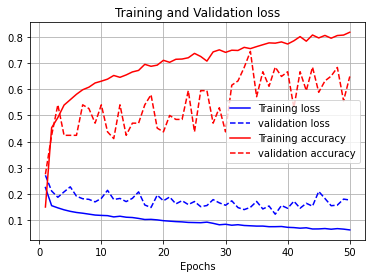

In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test f1_score : ", scores[1])


loss = history.history['loss']
loss_val = history.history['val_loss']
accuracy = history.history['get_f1']
accuracy_val = history.history['val_get_f1']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'b--', label='validation loss')
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'r--', label='validation accuracy')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Save the plot with few caracteristics in the name
scores[1] = str(scores[1]).replace(".",",")
lstm_dropout = str(lstm_dropout).replace(".",",")
print(scores[1])
plt.savefig('HateSpeech FastText 1BidiLSTM f1_score {} drop {} sizeLSTM {}.png'.format(scores[1], lstm_dropout, lstm_size))

0,8018674850463867


<Figure size 432x288 with 0 Axes>